## Annexe

#### 1. Function to analyze descriptive statistics for a given country

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def describe_country(data, country=None):
    """
    Describe the country data.

    Parameters:
    data (pd.DataFrame): The data to describe.
    country (str, optional): The country to filter by. Defaults to None.

    Returns:
    tuple: A tuple containing the number of rows, unique collections, top collection, unique references, top reference, and a list of unique collections.
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Create a summary of the object columns if needed
    summary = data.describe(include="object")
    
    # Extract required details directly from the original data
    number_rows = data.shape[0]
    number_unique_collections = data['collection'].nunique()
    top_collection = data['collection'].mode()[0]
    
    number_unique_references = data['reference'].nunique()
    top_reference = data['reference'].mode()[0]
    
    collection_list = data['collection'].unique()
    
    return number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list


#### 2. Visualization

In [7]:
def collection_visualization(data, country=None):
    """
    Visualize the collection data.

    Parameters:
    data (pd.DataFrame): The data to visualize.
    country (str): The country to filter by.

    Returns:
    None
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Choose a color palette
    palette = sns.color_palette("pastel")  # You can choose different palettes like "deep", "pastel", etc.

    # Create the count plot
    ax = sns.countplot(x="collection", data=data, palette=palette)

    # Add the count value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Labels and title
    plt.xlabel("Collection")
    plt.ylabel("Watch Count")
    plt.title(f"Watch Count per Collection in {country}")

    # Show the plot
    plt.show()

#### 3. Function to analyze the cheapest and most expensive products for a given country

In [8]:
def analyze_country(data, country=None):
    """
    Analyze the country data.

    Parameters:
    data (pd.DataFrame): The data to analyze.
    country (str, optional): The country to filter by. Defaults to None.

    Returns:
    tuple: A tuple containing the overall statistics and the collection statistics.
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Identify the cheapest and most expensive product in the whole subset
    cheapest_product_data = data.nsmallest(1, 'price')
    most_expensive_product_data = data.nlargest(1, 'price')
    
    overall_stats = {
        "cheapest": {
            "collection": cheapest_product_data['collection'].values[0],
            "reference": cheapest_product_data['reference'].values[0],
            "price": cheapest_product_data['price'].values[0]
        },
        "most_expensive": {
            "collection": most_expensive_product_data['collection'].values[0],
            "reference": most_expensive_product_data['reference'].values[0],
            "price": most_expensive_product_data['price'].values[0]
        }
    }
    
    # Identify the cheapest and most expensive product per collection
    collection_stats = []
    unique_collections = data["collection"].unique()
    
    for collection in unique_collections:
        collection_data = data[data["collection"] == collection]
        
        cheapest_collection_data = collection_data.nsmallest(1, 'price')
        most_expensive_collection_data = collection_data.nlargest(1, 'price')
        
        collection_stats.append({
            "collection": collection,
            "cheapest": {
                "reference": cheapest_collection_data['reference'].values[0],
                "price": cheapest_collection_data['price'].values[0]
            },
            "most_expensive": {
                "reference": most_expensive_collection_data['reference'].values[0],
                "price": most_expensive_collection_data['price'].values[0]
            }
        })
    
    return overall_stats, collection_stats

#### 4. Compute the difference of watch's price from this minimum

In [9]:
def calculate_price_difference(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), calculates the minimum price across all countries,
    computes the difference of each record's price from this minimum, and identifies the country that offers
    the minimum price.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns:
            - 'name': Product name.
            - 'country': Country of the product.
            - 'product_url': URL for the product.
            - 'collection'
            - 'reference'
            - 'price_USD'
    
    Returns:
        pd.DataFrame: The input DataFrame with additional columns:
                      - 'min_price': The minimum price for each product.
                      - 'price_diff': The difference between the price and the minimum price.
                      - 'min_price_country': The country corresponding to the minimum price.
                      The resulting DataFrame is re-ordered to include 'name', 'country', 'min_price_country', and 'product_url'.
    """
    df = data.copy()
    group_cols = ['collection', 'reference']
    
    # Calculate the minimum price for each product group
    df['min_price'] = df.groupby(group_cols)['price_USD'].transform('min')
    
    # Calculate the price difference from the minimum price
    df['price_diff'] = df['price_USD'] - df['min_price']
    
    # Determine the country corresponding to the minimum price for each group.
    # This finds the index of the minimum price for each group and extracts the country.
    min_price_country_df = df.loc[df.groupby(group_cols)['price_USD'].idxmin(), group_cols + ['country']]
    min_price_country_df = min_price_country_df.rename(columns={'country': 'min_price_country'})
    
    # Merge the min_price_country back into the main DataFrame using the group columns as key.
    df = df.merge(min_price_country_df, on=group_cols, how='left')
    
    # Reorder columns for clarity in the CSV output.
    desired_columns = ['name', 'country', 'min_price_country', 'product_url', 'collection', 'reference', 'price_USD', 'min_price', 'price_diff']
    available_columns = [col for col in desired_columns if col in df.columns]
    df = df[available_columns]
    
    # Save the result to a CSV file.
    df.to_csv('price_difference.csv', index=False)
    
    return df

#### 5. Identify the cheapest price and its corresponding country

In [10]:
def find_cheapest_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), identifies the cheapest price and its corresponding country.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns 'collection', 'reference', 'price_USD', and 'country'.
    
    Returns:
        pd.DataFrame: A DataFrame containing:
                      - 'collection'
                      - 'reference'
                      - 'cheapest_price': The lowest price found for the product.
                      - 'cheapest_country': The country corresponding to the cheapest price.
    """
    group_cols = ['collection', 'reference']
    cheapest = data.loc[data.groupby(group_cols)['min_price'].idxmin()].copy()
    cheapest = cheapest[['collection', 'reference', 'price_USD', 'country']]
    cheapest.rename(columns={'price_USD': 'cheapest_price', 'country': 'cheapest_country'}, inplace=True)
    cheapest.to_csv('cheapest_prices.csv', index=False)
    
    return cheapest

#### 6. Identify the best selling options

In [11]:
def find_best_sell_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), identifies the best selling option,
    defined as the country where the product has the highest price. Also calculates potential profit
    by finding the difference between the best selling price and the minimum price.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns:
            - 'collection'
            - 'reference'
            - 'price_USD'
            - 'country'

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'collection'
            - 'reference'
            - 'best_sell_price': The highest price found for the product.
            - 'best_sell_country': The country corresponding to the highest price.
            - 'min_price': The minimum price for the product.
            - 'min_price_country': The country where the minimum price is found.
            - 'profit': The potential profit from buying at the cheapest price and selling at the highest price.
    """
    group_cols = ['collection', 'reference']

    # Find the best selling price (highest price) and the country
    best_sell = data.loc[data.groupby(group_cols)['price_USD'].idxmax()].copy()
    best_sell = best_sell[['collection', 'reference', 'price_USD', 'country']]
    best_sell.rename(columns={'price_USD': 'best_sell_price', 'country': 'best_sell_country'}, inplace=True)

    # Find the minimum price and its country
    min_price = data.loc[data.groupby(group_cols)['price_USD'].idxmin()].copy()
    min_price = min_price[['collection', 'reference', 'price_USD', 'country']]
    min_price.rename(columns={'price_USD': 'min_price', 'country': 'min_price_country'}, inplace=True)

    # Merge both DataFrames to have best selling and minimum price information in one table
    result = pd.merge(best_sell, min_price, on=['collection', 'reference'], how='left')

    # Calculate potential profit
    result['profit'] = result['best_sell_price'] - result['min_price']

    # Save the results
    result.to_csv('best_sell_prices_with_profit.csv', index=False)
    
    return result

#### 7. The sum of potential profits per collection

In [12]:
def sum_profit(data: pd.DataFrame):
    """
    Computes the sum of potential profits per collection.

    Parameters:
        data (pd.DataFrame): DataFrame with best sell prices and profit computed.

    Returns:
        Dictionary of DataFrames:
            - 'profit_by_reference': Profit summed per country based on product reference.
            - 'profit_by_collection': Profit summed per country based on collection.
    """
    
    # Aggregate total profit per country (based on reference)
    global_profit = data['profit'].sum()

    # Aggregate total profit per country (based on collection)
    profit_by_collection = data.groupby('collection', as_index=False)['profit'].sum()
    profit_by_collection.rename(columns={'profit': 'total_profit_by_collection ($)'}, inplace=True)

    return {
        "global_profit": global_profit,
        "profit_by_collection": profit_by_collection
    }

#### 8. Products Availability

In [80]:
def available_product(data, country=None):
    if country:
        data = data[data['country'] == country]

    data = data[data['availability'] == 'Available']
    total_available_products = len(data['availability'].values)
    data = data[['country', 'collection', 'reference', 'price_USD']]
    
    if country:
        data.to_csv(f"../data/gold/Available_product_{country}_2025.csv")
    data.to_csv(f"../data/gold/Available_product_2025.csv", index=False)
    
    return data, total_available_products

# 1. Import librariries

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load & Read the Data

In [82]:
data = pd.read_csv(r"../data/silver/2025-03-01_13-24-45/PANERAI_DATA_2025.csv")
data.head()

,reference,year,image_url,collection,brand,country,price,product_url,currency,name,availability,currency_code,price_JPY,price_USD,price_GBP,price_EUR
0,PAM01570,2025,https://www.panerai.com/content/dam/rcq/pan/km...,Radiomir,PANERAI,USA,6000,https://www.panerai.com/us/en/collections/watc...,$,Radiomir Quaranta,Available,USD,903423.0,6000.0,4764.0,5776.80
1,PAM01571,2025,https://www.panerai.com/content/dam/rcq/pan/Ot...,Radiomir,PANERAI,USA,6000,https://www.panerai.com/us/en/collections/watc...,$,Radiomir Quaranta,Out of Stock,USD,903423.0,6000.0,4764.0,5776.80
2,PAM01572,2025,https://www.panerai.com/content/dam/rcq/pan/lz...,Radiomir,PANERAI,USA,6000,https://www.panerai.com/us/en/collections/watc...,$,Radiomir Quaranta,Available,USD,903423.0,6000.0,4764.0,5776.80
3,PAM01573,2025,https://www.panerai.com/content/dam/rcq/pan/iY...,Radiomir,PANERAI,USA,6000,https://www.panerai.com/us/en/collections/watc...,$,Radiomir Quaranta,Available,USD,903423.0,6000.0,4764.0,5776.80
4,PAM01385,2025,https://www.panerai.com/content/dam/rcq/pan/bc...,Radiomir,PANERAI,USA,5400,https://www.panerai.com/us/en/collections/watc...,$,Radiomir Officine,Out of Stock,USD,813080.7,5400.0,4287.6,5199.12


# 3. Exploratory Data Analysis (EDA)

### 3.1. Columns list

In [83]:
column_list = list(data.columns)

print("List of column name:\n")
for i in range(len(column_list)):
    print(f"\t{i+1}. {column_list[i]}")

List of column name:

	1. reference
	2. year
	3. image_url
	4. collection
	5. brand
	6. country
	7. price
	8. product_url
	9. currency
	10. name
	11. availability
	12. currency_code
	13. price_JPY
	14. price_USD
	15. price_GBP
	16. price_EUR


### 3.2. Data types discovery

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reference      590 non-null    object 
 1   year           590 non-null    int64  
 2   image_url      590 non-null    object 
 3   collection     590 non-null    object 
 4   brand          590 non-null    object 
 5   country        590 non-null    object 
 6   price          590 non-null    int64  
 7   product_url    590 non-null    object 
 8   currency       590 non-null    object 
 9   name           590 non-null    object 
 10  availability   590 non-null    object 
 11  currency_code  590 non-null    object 
 12  price_JPY      590 non-null    float64
 13  price_USD      590 non-null    float64
 14  price_GBP      590 non-null    float64
 15  price_EUR      590 non-null    float64
dtypes: float64(4), int64(2), object(10)
memory usage: 73.9+ KB


--------------------------------------------------------------------------------------

**The dataset we used in the following use case contains**:

    1. 590 row of data
    
    2. 10 categoircal columns
    
    3. 6 numerical column
--------------------------------------------------------------------------------------

### 3.3. Check Missing Values

In [85]:
data.isna().sum()

reference        0
year             0
image_url        0
collection       0
brand            0
country          0
price            0
product_url      0
currency         0
name             0
availability     0
currency_code    0
price_JPY        0
price_USD        0
price_GBP        0
price_EUR        0
dtype: int64

--------------------------------------------------------------------------------------

**Now, the dataset is clean, no more missing values**

    ** -> We are ready to GO **

--------------------------------------------------------------------------------------

### 3.4. Check for duplicates bases on 'reference' and 'country'

In [86]:
# Check for duplicates based on 'reference', 'country', and 'collection'
duplicates = data.duplicated(subset=['reference', 'country']).sum()

# Display the duplicate rows
print(duplicates)

0


### 3.5. Descriptive statistics

In [87]:
stats = data.describe(include="object")
stats

,reference,image_url,collection,brand,country,product_url,currency,name,availability,currency_code
count,590,590,590,590,590,590,590,590,590,590
unique,149,149,4,1,4,590,4,174,2,4
top,PAM01570,https://www.panerai.com/content/dam/rcq/pan/km...,Luminor,PANERAI,USA,https://www.panerai.com/us/en/collections/watc...,$,Luminor Due,Available,USD
freq,4,4,215,590,149,1,149,41,418,149


In [88]:
# Now use the function on your original data
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data)

print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    # Use the original data for lookup, not the summary!
    collection_for_top_reference = data[data['reference'] == top_reference]['collection'].iloc[0]
    print(f"\nWe have a total of {number_unique_references} distinct products, with {top_reference} leading the selection from the {collection_for_top_reference} collection")


Number of rows: 590

We have 4 collections, and Luminor is the leading one

Catalog of Collections:
1. Radiomir
2. Luminor
3. Submersible
4. Luminor Due

We have a total of 149 distinct products, with PAM00422 leading the selection from the Luminor collection


In [89]:
# Brand
number_unique_brands, top_brand = stats["brand"].unique()[1], stats["brand"].unique()[2]
if number_unique_brands == 1:
    print(f"There is a unique brand, named {top_brand}")
else:
    print(f"There is {number_unique_brands} brands, and {top_brand} is the leading one")

There is a unique brand, named PANERAI


In [90]:
# Countries
number_unique_countries, top_country = stats["country"].unique()[1], stats["country"].unique()[2]
if number_unique_countries == 1:
    print(f"Our study is applied to a unique country, {top_country}")
else:
    print(f"Our study is applied to {number_unique_countries} countries, with {top_country} being the top one")

Our study is applied to 4 countries, with USA being the top one


In [91]:
countries_list = data["country"].unique()

print("Countries Included in the Study:\n")
for i in range(len(countries_list)):
    print(f"\t{i+1}. {countries_list[i]}")

Countries Included in the Study:

	1. USA
	2. France
	3. UK
	4. Japan


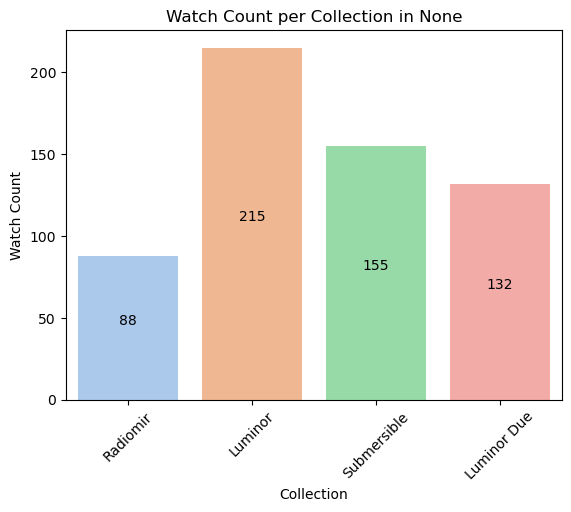

In [92]:
collection_visualization(data)

## 4. Business Analysis

## 4.1. Analysis of the global data

#### 4.1.1. Top products with the highest price difference (difference from the minimum price)

In [93]:
data_with_diff = calculate_price_difference(data)

print("Top 5 products with the highest price difference:")
# Group by product and pick the row with the maximum price difference per product
top_diff = data_with_diff.sort_values('price_diff', ascending=False).drop_duplicates(subset=['collection', 'reference'])
top_diff.head()

Top 5 products with the highest price difference:


,name,country,min_price_country,product_url,collection,reference,price_USD,min_price,price_diff
230,Submersible Tourbillon GMT Luna Rossa Experien...,France,USA,https://www.panerai.com/fr/fr/collections/watc...,Submersible,PAM01405,202527.000,168200.0,34327.000
223,Luminor Tourbillon GMT,France,USA,https://www.panerai.com/fr/fr/collections/watc...,Luminor,PAM01060,196295.400,163700.0,32595.400
517,Luminor Tourbillon Moon Phases Equation of Tim...,Japan,USA,https://www.panerai.com/jp/ja/collections/watc...,Luminor,PAM00920,264663.773,233800.0,30863.773
164,Radiomir Tourbillon GMT Bronzo,France,USA,https://www.panerai.com/fr/fr/collections/watc...,Radiomir,PAM01284,176562.000,146700.0,29862.000
258,Submersible Elux LAB-ID,France,USA,https://www.panerai.com/fr/fr/collections/watc...,Submersible,PAM01800,112168.800,93200.0,18968.800


#### 4.1.2. The Product Offered by the Country with the Cheapest Price

In [94]:
cheapest_prices = find_cheapest_prices(data_with_diff)

print("\nCheapest prices per product:")
print(cheapest_prices.head())


Cheapest prices per product:
   collection reference  cheapest_price cheapest_country
33    Luminor  PAM00422         11300.0              USA
74    Luminor  PAM00670         24000.0              USA
72    Luminor  PAM00715         62400.0              USA
71    Luminor  PAM00742         45100.0              USA
30    Luminor  PAM00914          7100.0              USA


#### 4.1.3. The best selling option

In [95]:
best_sell_prices = find_best_sell_prices(data)

print("\nBest selling prices by product (sample):")
best_sell_prices.head(5)


Best selling prices by product (sample):


,collection,reference,best_sell_price,best_sell_country,min_price,min_price_country,profit
0,Luminor,PAM00422,12342.12,UK,11300.000,USA,1042.120
1,Luminor,PAM00670,26069.58,UK,24000.000,USA,2069.580
2,Luminor,PAM00715,74779.20,France,62400.000,USA,12379.200
3,Luminor,PAM00742,54007.20,France,45100.000,USA,8907.200
4,Luminor,PAM00914,7682.34,UK,7085.947,Japan,596.393


#### 4.1.4. The sum of potential profits per collection

In [96]:
# Run the function
profits = sum_profit(best_sell_prices)

# Print the results
print(f"Total Profit: {profits['global_profit']} $")

print("\nProfit by Collection:")
print(profits["profit_by_collection"])


Total Profit: 408164.128 $

Profit by Collection:
    collection  total_profit_by_collection ($)
0      Luminor                      143942.128
1  Luminor Due                       43003.756
2     Radiomir                       78308.361
3  Submersible                      142909.883


#### 4.1.5. Products availabality

In [122]:
available_products, total_available_products = available_product(data)

print(f"Total of Available products : {total_available_products}")
print(available_products.head(5))

Total of Available products : 114
    country collection reference  price_USD
149  France   Radiomir  PAM01570    6335.46
150  France   Radiomir  PAM01571    6335.46
151  France   Radiomir  PAM01572    6335.46
152  France   Radiomir  PAM01573    6335.46
154  France   Radiomir  PAM01384    5712.30


## 4.2. Analysis for a given country

### 4.2.1. France

In [148]:
country = "France"

In [149]:
# Now use the function on your original data
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country = "France")

print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    # Use the original data for lookup, not the summary!
    collection_for_top_reference = data[data['reference'] == top_reference]['collection'].iloc[0]
    print(f"\nWe have a total of {number_unique_references} distinct products, with {top_reference} leading the selection from the {collection_for_top_reference} collection")


Number of rows: 146

We have 4 collections, and Luminor is the leading one

Catalog of Collections:
1. Radiomir
2. Luminor
3. Submersible
4. Luminor Due

We have a total of 146 distinct products, with PAM00422 leading the selection from the Luminor collection


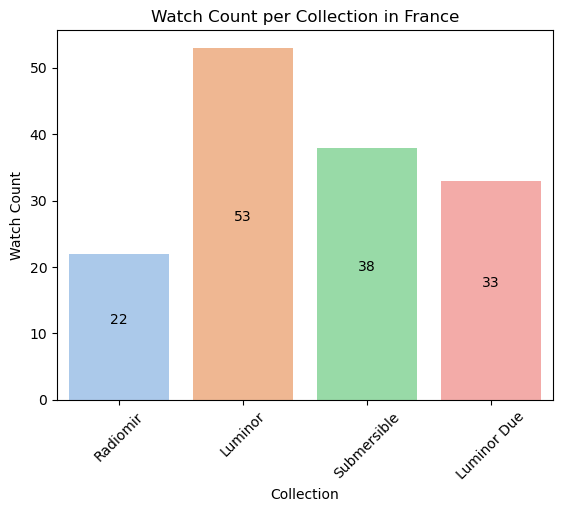

In [150]:
collection_visualization(data, country)

In [151]:
overall_stats, collection_stats = analyze_country(data, country)

#### Identify the cheapest and most expensive product in the whole subset

In [152]:
overall_stats, collection_stats = analyze_country(data, country)

print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in France:
  Cheapest -> Collection: Radiomir, Reference: PAM01383, Price: 5000 €
  Most Expensive -> Collection: Submersible, Reference: PAM01405, Price: 195000 €


#### Identify the cheapest and most expensive product per collection

In [153]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: Radiomir
  Cheapest -> Reference: PAM01383, Price: 5000 €
  Most Expensive -> Reference: PAM01284, Price: 170000 €

--------------------------------------------------

Collection: Luminor
  Cheapest -> Reference: PAM01623, Price: 5700 €
  Most Expensive -> Reference: PAM01060, Price: 189000 €

--------------------------------------------------

Collection: Submersible
  Cheapest -> Reference: PAM01590, Price: 9700 €
  Most Expensive -> Reference: PAM01405, Price: 195000 €

--------------------------------------------------

Collection: Luminor Due
  Cheapest -> Reference: PAM01248, Price: 7000 €
  Most Expensive -> Reference: PAM01494, Price: 42000 €

--------------------------------------------------



#### Products availabality

In [154]:
available_products, total_available_products = available_product(data, country = country)

print(f"Total of Available products : {total_available_products}")
print(available_products.head(5))

Total of Available products : 114
    country collection reference  price_USD
149  France   Radiomir  PAM01570    6335.46
150  France   Radiomir  PAM01571    6335.46
151  France   Radiomir  PAM01572    6335.46
152  France   Radiomir  PAM01573    6335.46
154  France   Radiomir  PAM01384    5712.30


### 4.2.2. UK

In [155]:
country = "UK"

In [156]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 148

We have 4 collections, and Luminor is the leading one

Catalog of Collections:
1. Radiomir
2. Luminor
3. Submersible
4. Luminor Due

We have a Total of 148 distinct products, with PAM00422 leading the selection from Luminor collection


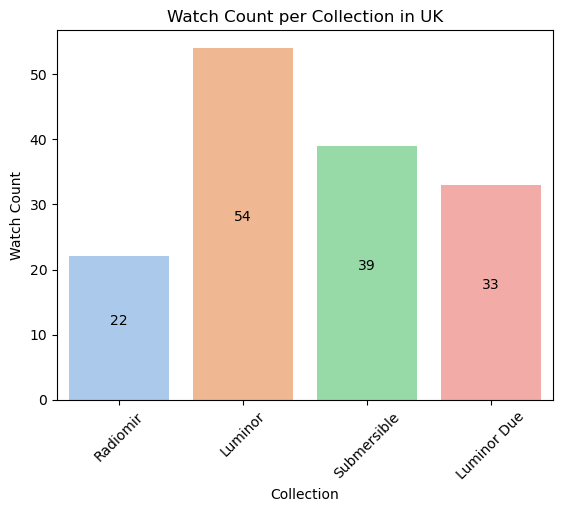

In [157]:
collection_visualization(data, country)

In [158]:
overall_stats, collection_stats = analyze_country(data, country)

In [159]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in UK:
  Cheapest -> Collection: Radiomir, Reference: PAM01383, Price: 4300 £
  Most Expensive -> Collection: Luminor, Reference: PAM00920, Price: 188200 £


In [160]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: Radiomir
  Cheapest -> Reference: PAM01383, Price: 4300 £
  Most Expensive -> Reference: PAM01284, Price: 118500 £

--------------------------------------------------

Collection: Luminor
  Cheapest -> Reference: PAM01623, Price: 4900 £
  Most Expensive -> Reference: PAM00920, Price: 188200 £

--------------------------------------------------

Collection: Submersible
  Cheapest -> Reference: PAM01590, Price: 8200 £
  Most Expensive -> Reference: PAM01405, Price: 135900 £

--------------------------------------------------

Collection: Luminor Due
  Cheapest -> Reference: PAM01248, Price: 6000 £
  Most Expensive -> Reference: PAM01494, Price: 35500 £

--------------------------------------------------



#### Products availabality

In [161]:
available_products, total_available_products = available_product(data, country = country)

print(f"Total of Available products in {country} : {total_available_products}")
print(available_products.head(5))

Total of Available products in UK : 110
    country collection reference  price_USD
295      UK   Radiomir  PAM01570    6548.88
296      UK   Radiomir  PAM01571    6548.88
297      UK   Radiomir  PAM01572    6548.88
298      UK   Radiomir  PAM01573    6548.88
300      UK   Radiomir  PAM01384    5919.18


### 4.2.3. Japan

In [162]:
country = "Japan"

In [163]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 147

We have 4 collections, and Luminor is the leading one

Catalog of Collections:
1. Radiomir
2. Luminor
3. Submersible
4. Luminor Due

We have a Total of 147 distinct products, with PAM00422 leading the selection from Luminor collection


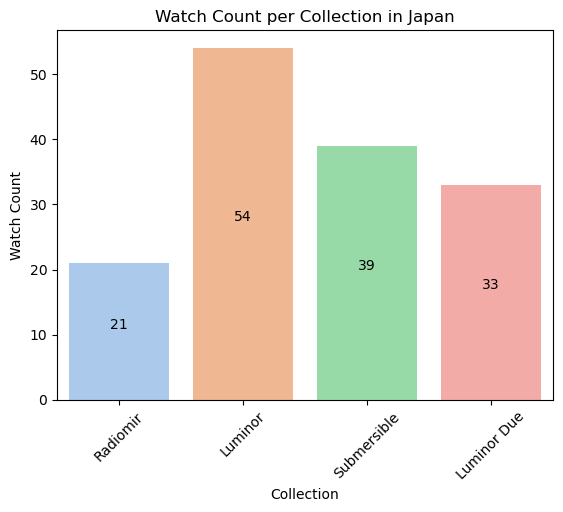

In [164]:
collection_visualization(data, country)

In [165]:
overall_stats, collection_stats = analyze_country(data, country)

In [166]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in Japan:
  Cheapest -> Collection: Radiomir, Reference: PAM01383, Price: 748000 ￥
  Most Expensive -> Collection: Luminor, Reference: PAM00920, Price: 39853000 ￥


In [167]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: Radiomir
  Cheapest -> Reference: PAM01383, Price: 748000 ￥
  Most Expensive -> Reference: PAM01284, Price: 25091000 ￥

--------------------------------------------------

Collection: Luminor
  Cheapest -> Reference: PAM01623, Price: 847000 ￥
  Most Expensive -> Reference: PAM00920, Price: 39853000 ￥

--------------------------------------------------

Collection: Submersible
  Cheapest -> Reference: PAM01590, Price: 1441000 ￥
  Most Expensive -> Reference: PAM01405, Price: 28776000 ￥

--------------------------------------------------

Collection: Luminor Due
  Cheapest -> Reference: PAM01248, Price: 1045000 ￥
  Most Expensive -> Reference: PAM01494, Price: 6215000 ￥

--------------------------------------------------



#### Products availabality

In [168]:
available_products, total_available_products = available_product(data, country = country)

print(f"Total of Available products in {country} : {total_available_products}")
print(available_products.head(5))

Total of Available products in Japan : 95
    country collection reference  price_USD
443   Japan   Radiomir  PAM01570   6063.233
444   Japan   Radiomir  PAM01571   6063.233
445   Japan   Radiomir  PAM01572   6063.233
446   Japan   Radiomir  PAM01573   6063.233
448   Japan   Radiomir  PAM01384   5405.774


### 4.2.4. USA

In [169]:
country = "USA"

In [170]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 149

We have 4 collections, and Luminor is the leading one

Catalog of Collections:
1. Radiomir
2. Luminor
3. Submersible
4. Luminor Due

We have a Total of 149 distinct products, with PAM00422 leading the selection from Luminor collection


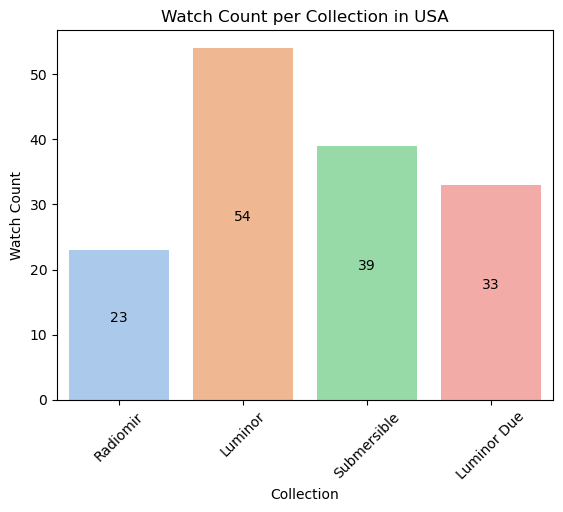

In [171]:
collection_visualization(data, country)

In [172]:
overall_stats, collection_stats = analyze_country(data, country)

In [173]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in USA:
  Cheapest -> Collection: Radiomir, Reference: PAM01383, Price: 4900 $
  Most Expensive -> Collection: Radiomir, Reference: PAM00600, Price: 396800 $


In [174]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: Radiomir
  Cheapest -> Reference: PAM01383, Price: 4900 $
  Most Expensive -> Reference: PAM00600, Price: 396800 $

--------------------------------------------------

Collection: Luminor
  Cheapest -> Reference: PAM01623, Price: 5600 $
  Most Expensive -> Reference: PAM00920, Price: 233800 $

--------------------------------------------------

Collection: Submersible
  Cheapest -> Reference: PAM01590, Price: 9500 $
  Most Expensive -> Reference: PAM01405, Price: 168200 $

--------------------------------------------------

Collection: Luminor Due
  Cheapest -> Reference: PAM01248, Price: 6900 $
  Most Expensive -> Reference: PAM01494, Price: 41200 $

--------------------------------------------------



#### Products availabality

In [175]:
available_products, total_available_products = available_product(data, country = country)

print(f"Total of Available products in {country} : {total_available_products}")
print(available_products.head(5))

Total of Available products in USA : 99
  country collection reference  price_USD
0     USA   Radiomir  PAM01570     6000.0
2     USA   Radiomir  PAM01572     6000.0
3     USA   Radiomir  PAM01573     6000.0
5     USA   Radiomir  PAM01384     5400.0
6     USA   Radiomir  PAM01383     4900.0
